## Create data

<AxesSubplot:xlabel='idx'>

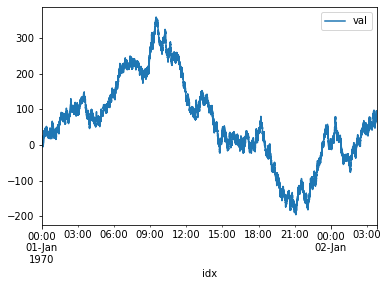

In [1]:
import oocas as oc
import numpy as np
import pandas as pd
from pathlib import Path


n = 10**5
df = pd.DataFrame({
    'idx': pd.to_datetime(np.arange(n), unit='s'),
    'val': np.cumsum(np.random.normal(size=n))
    }).set_index('idx')
df.plot()

In [2]:
nfiles = 10
paths = [Path('data', 'raw', f"{i}_random_walk.parquet") for i in range(nfiles)]

for chunk, path in zip(np.array_split(df, len(paths)), paths):
    chunk.to_parquet(path)

In [3]:
paths = oc.find_paths('data/raw')
paths

[WindowsPath('data/raw/0_random_walk.parquet'),
 WindowsPath('data/raw/1_random_walk.parquet'),
 WindowsPath('data/raw/2_random_walk.parquet'),
 WindowsPath('data/raw/3_random_walk.parquet'),
 WindowsPath('data/raw/4_random_walk.parquet'),
 WindowsPath('data/raw/5_random_walk.parquet'),
 WindowsPath('data/raw/6_random_walk.parquet'),
 WindowsPath('data/raw/7_random_walk.parquet'),
 WindowsPath('data/raw/8_random_walk.parquet'),
 WindowsPath('data/raw/9_random_walk.parquet')]

## Read files to dataframe

In [4]:
paths = oc.find_paths('data/raw')
sqp = oc.Process(oc.ParquetRead(), progress_bar=False)
df = pd.concat(sqp(paths), axis=0)
print(f"nrows: {len(df)}")
df.tail()

nrows: 100000


,val
idx,
1970-01-02 03:46:35,93.400126
1970-01-02 03:46:36,92.369964
1970-01-02 03:46:37,93.776417
1970-01-02 03:46:38,95.057941
1970-01-02 03:46:39,95.272390


## Random sampling

  0%|          | 0/10 [00:00<?, ?it/s]

nrows: 1000


<AxesSubplot:xlabel='idx'>

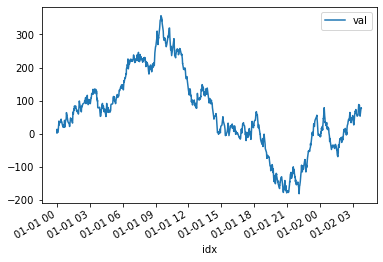

In [5]:
sqp = oc.Process(
    oc.ParquetMetaDataRead(),
    lambda x: x.num_rows,
    progress_bar=False)

nrows = sum(sqp(paths))                     
sample_idxs = np.random.choice(nrows, 10**3)

def sample(df, cache):
    adjusted_idxs = sample_idxs - cache.data    # Normalize sample indices
    cache(cache.data + len(df))                 # Increment position for later
    return df.iloc[[                                      
        idx for idx in adjusted_idxs\
             if idx >= 0 and idx < len(df)      # Select sampled rows
    ]].copy()                                   # Copy to avoid reference

sqp = oc.Process(
    oc.ParquetRead(),
    oc.CacheTransform(sample, cache=0))         # Initialize cache data with 0

sample_df = pd.concat(sqp(paths), axis=0)
print(f"nrows: {len(sample_df)}")
sample_df.plot()

## Moving average

In [6]:
def moving_average(df, cache):
    nrows = len(df)                             # Number of current rows
    df = pd.concat([cache.data, df])            # Prepend past to current
    cache(df)                                   # Update past for next iteration
    return df.rolling(cache.lookback)\
        .mean().iloc[-nrows:]                   # Return result for current rows
    
sqp = oc.Process(
    oc.ParquetRead(),
    oc.CacheTransform(                          # Passes dataframe and cache
        moving_average,                         # Transform
        oc.TimeIndexCache('1H')),               # Cache recent hour
    oc.ParquetWrite(
        path_part_replace=('raw', 'mavg'),      # Change directory
        overwrite=True,
        mkdirs=True))                           # Create dirs if not exist

mavg_paths = sqp(paths)
mavg_paths

  0%|          | 0/10 [00:00<?, ?it/s]

[WindowsPath('data/mavg/0_random_walk.parquet'),
 WindowsPath('data/mavg/1_random_walk.parquet'),
 WindowsPath('data/mavg/2_random_walk.parquet'),
 WindowsPath('data/mavg/3_random_walk.parquet'),
 WindowsPath('data/mavg/4_random_walk.parquet'),
 WindowsPath('data/mavg/5_random_walk.parquet'),
 WindowsPath('data/mavg/6_random_walk.parquet'),
 WindowsPath('data/mavg/7_random_walk.parquet'),
 WindowsPath('data/mavg/8_random_walk.parquet'),
 WindowsPath('data/mavg/9_random_walk.parquet')]

  0%|          | 0/10 [00:00<?, ?it/s]

nrows: 100000


<AxesSubplot:xlabel='idx'>

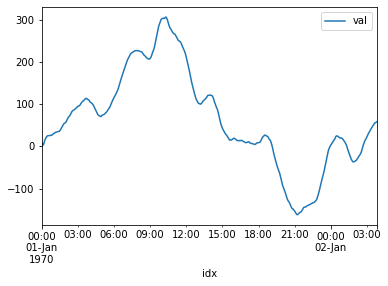

In [7]:
sqp = oc.Process(oc.ParquetRead())
mavg_df = pd.concat(sqp(mavg_paths), axis=0)
print(f"nrows: {len(mavg_df)}")
mavg_df.plot()

## N-to-1 file write

In [8]:
pickle_multi_to_one_write = oc.FileWrite(
    lambda x, path, **kwargs:\
         x.to_pickle(path, **kwargs),
    path_transform=lambda x: x[0],              # Select first path
    path_part_replace=('raw', 'pickle'),        # Change directory
    name_transform=lambda x:\
         '_'.join(x.split('_')[1:]),            # Remove unique first part
    suffix='.pkl.gz',                           # Replace suffix
    mkdirs=True,                                # Create dirs if not exist
    overwrite=True,                             # Overwrite if files exist
    compression='infer')                        # Pass to_pickle() argument


pickle_multi_to_one_write(df, paths)

WindowsPath('data/pickle/random_walk.pkl.gz')

In [9]:
all_files = oc.find_paths('data', pattern='*.parquet', recursive=True)
multipaths = list(zip(*all_files))
multipaths

[(WindowsPath('data/mavg/0_random_walk.parquet'),
  WindowsPath('data/raw/0_random_walk.parquet')),
 (WindowsPath('data/mavg/1_random_walk.parquet'),
  WindowsPath('data/raw/1_random_walk.parquet')),
 (WindowsPath('data/mavg/2_random_walk.parquet'),
  WindowsPath('data/raw/2_random_walk.parquet')),
 (WindowsPath('data/mavg/3_random_walk.parquet'),
  WindowsPath('data/raw/3_random_walk.parquet')),
 (WindowsPath('data/mavg/4_random_walk.parquet'),
  WindowsPath('data/raw/4_random_walk.parquet')),
 (WindowsPath('data/mavg/5_random_walk.parquet'),
  WindowsPath('data/raw/5_random_walk.parquet')),
 (WindowsPath('data/mavg/6_random_walk.parquet'),
  WindowsPath('data/raw/6_random_walk.parquet')),
 (WindowsPath('data/mavg/7_random_walk.parquet'),
  WindowsPath('data/raw/7_random_walk.parquet')),
 (WindowsPath('data/mavg/8_random_walk.parquet'),
  WindowsPath('data/raw/8_random_walk.parquet')),
 (WindowsPath('data/mavg/9_random_walk.parquet'),
  WindowsPath('data/raw/9_random_walk.parquet'))]